# Time Series Forecasting with *scikit-learn* 

In [2]:
import numpy as np
import pandas as pd
# import statsmodels.api as sm
import matplotlib.pyplot as plt

## 1. Get the data 

In [3]:
df = pd.read_csv("./consumption_temp.csv")
grouped = df.groupby('location')
data = grouped.get_group('oslo')
# df['time'] = pd.to_datetime(df['time'])
# df.set_index('time', inplace=True)
data.head()

,time,location,consumption,temperature
1,2022-04-07 21:00:00,oslo,4.092830,1.0
6,2022-04-07 22:00:00,oslo,3.818095,0.4
11,2022-04-07 23:00:00,oslo,3.660981,0.3
16,2022-04-08 00:00:00,oslo,3.584066,0.2
21,2022-04-08 01:00:00,oslo,3.549536,0.4


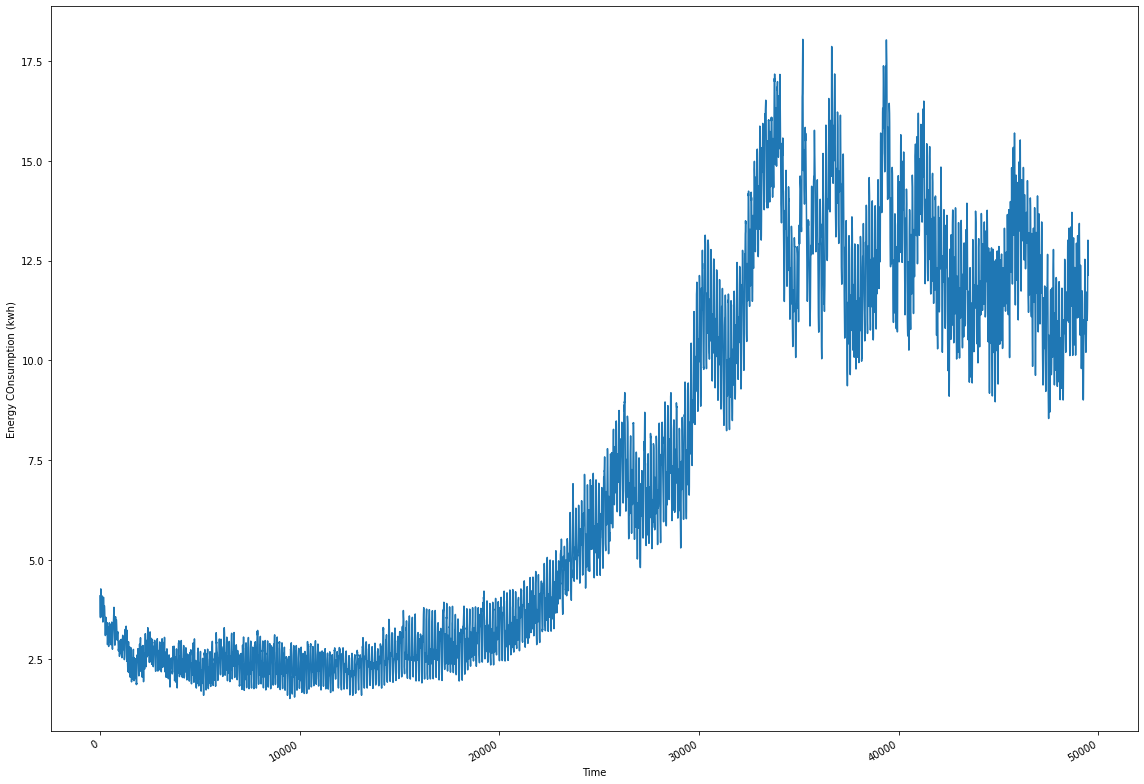

In [4]:
fig, ax = plt.subplots(figsize=(16, 11))

ax.plot(data['consumption'])
ax.set_xlabel('Time')
ax.set_ylabel('Energy COnsumption (kwh)')

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
data = data.interpolate()
data.isnull().sum()

time           0
location       0
consumption    0
temperature    0
dtype: int64

## Predict the next step using the last observation 

In [6]:
df = data.copy()

df['y'] = df['consumption'].shift(-1)
df

,time,location,consumption,temperature,y
1,2022-04-07 21:00:00,oslo,4.092830,1.0,3.818095
6,2022-04-07 22:00:00,oslo,3.818095,0.4,3.660981
11,2022-04-07 23:00:00,oslo,3.660981,0.3,3.584066
16,2022-04-08 00:00:00,oslo,3.584066,0.2,3.549536
21,2022-04-08 01:00:00,oslo,3.549536,0.4,3.552738
...,...,...,...,...,...
49466,2023-04-02 17:00:00,oslo,12.410225,5.5,12.856381
49472,2023-04-02 18:00:00,oslo,12.856381,4.8,13.010338
49478,2023-04-02 19:00:00,oslo,13.010338,0.6,12.738356
49484,2023-04-02 20:00:00,oslo,12.738356,-0.3,12.134655


In [7]:
train = df[:-104]
test = df[-104:]

print(f'Shape of training set: {train.shape}')
print(f'Shape of test set: {test.shape}')

Shape of training set: (8537, 5)
Shape of test set: (104, 5)


### Baseline model: repeat the last observation 

In [9]:
test = test.copy()
test['baseline_pred'] = test['consumption']

test = test.drop(test.tail(1).index) # Drop last row

test

,time,location,consumption,temperature,y,baseline_pred
48872,2023-03-29 14:00:00,oslo,10.962014,3.0,11.305941,10.962014
48878,2023-03-29 15:00:00,oslo,11.305941,2.8,11.482589,11.305941
48884,2023-03-29 16:00:00,oslo,11.482589,2.0,12.057691,11.482589
48890,2023-03-29 17:00:00,oslo,12.057691,0.3,12.645673,12.057691
48896,2023-03-29 18:00:00,oslo,12.645673,-2.0,12.933776,12.645673
...,...,...,...,...,...,...
49460,2023-04-02 16:00:00,oslo,11.643800,6.9,12.410225,11.643800
49466,2023-04-02 17:00:00,oslo,12.410225,5.5,12.856381,12.410225
49472,2023-04-02 18:00:00,oslo,12.856381,4.8,13.010338,12.856381
49478,2023-04-02 19:00:00,oslo,13.010338,0.6,12.738356,13.010338


### Apply a Decision Tree (can be replaced with any regressor model in sklearn) 

In [10]:
from sklearn.tree import DecisionTreeRegressor

X_train = train['consumption'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['consumption'].values.reshape(-1,1)

# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)

# Fit the model
dt_reg.fit(X=X_train, y=y_train)

# Make predictions
dt_pred = dt_reg.predict(X_test)

# Assign predictions to a new column in test
test['dt_pred'] = dt_pred

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
test

,time,location,consumption,temperature,y,baseline_pred,dt_pred
48872,2023-03-29 14:00:00,oslo,10.962014,3.0,11.305941,10.962014,11.649369
48878,2023-03-29 15:00:00,oslo,11.305941,2.8,11.482589,11.305941,12.364555
48884,2023-03-29 16:00:00,oslo,11.482589,2.0,12.057691,11.482589,10.747536
48890,2023-03-29 17:00:00,oslo,12.057691,0.3,12.645673,12.057691,11.665730
48896,2023-03-29 18:00:00,oslo,12.645673,-2.0,12.933776,12.645673,11.961624
...,...,...,...,...,...,...,...
49460,2023-04-02 16:00:00,oslo,11.643800,6.9,12.410225,11.643800,12.410225
49466,2023-04-02 17:00:00,oslo,12.410225,5.5,12.856381,12.410225,12.856381
49472,2023-04-02 18:00:00,oslo,12.856381,4.8,13.010338,12.856381,13.010338
49478,2023-04-02 19:00:00,oslo,13.010338,0.6,12.738356,13.010338,12.738356


In [12]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [13]:
baseline_mape = mape(test['y'], test['baseline_pred'])
dt_mape = mape(test['y'], test['dt_pred'])

print(f'Baseline: {baseline_mape}%')
print(f'Decision Tree: {dt_mape}%')

Baseline: 2.89%
Decision Tree: 2.77%


In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y=y_train.ravel())

gbr_pred = gbr.predict(X_test)

test['gbr_pred'] = gbr_pred

test

,time,location,consumption,temperature,y,baseline_pred,dt_pred,gbr_pred
48872,2023-03-29 14:00:00,oslo,10.962014,3.0,11.305941,10.962014,11.649369,11.120443
48878,2023-03-29 15:00:00,oslo,11.305941,2.8,11.482589,11.305941,12.364555,11.345772
48884,2023-03-29 16:00:00,oslo,11.482589,2.0,12.057691,11.482589,10.747536,11.468256
48890,2023-03-29 17:00:00,oslo,12.057691,0.3,12.645673,12.057691,11.665730,11.898748
48896,2023-03-29 18:00:00,oslo,12.645673,-2.0,12.933776,12.645673,11.961624,12.640031
...,...,...,...,...,...,...,...,...
49460,2023-04-02 16:00:00,oslo,11.643800,6.9,12.410225,11.643800,12.410225,11.646165
49466,2023-04-02 17:00:00,oslo,12.410225,5.5,12.856381,12.410225,12.856381,12.407892
49472,2023-04-02 18:00:00,oslo,12.856381,4.8,13.010338,12.856381,13.010338,12.748384
49478,2023-04-02 19:00:00,oslo,13.010338,0.6,12.738356,13.010338,12.738356,12.927546


In [16]:
gbr_mape = mape(test['consumption'], test['gbr_pred'])

print(f'Gradient Boosting Regressor: {gbr_mape}%')

Gradient Boosting Regressor: 0.62%


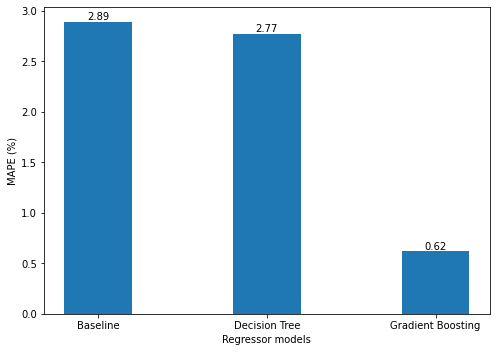

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
# ax.set_ylim(0, 0.3)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

## Predict the next step with a window as input 

In [19]:
data

,time,location,consumption,temperature
1,2022-04-07 21:00:00,oslo,4.092830,1.0
6,2022-04-07 22:00:00,oslo,3.818095,0.4
11,2022-04-07 23:00:00,oslo,3.660981,0.3
16,2022-04-08 00:00:00,oslo,3.584066,0.2
21,2022-04-08 01:00:00,oslo,3.549536,0.4
...,...,...,...,...
49466,2023-04-02 17:00:00,oslo,12.410225,5.5
49472,2023-04-02 18:00:00,oslo,12.856381,4.8
49478,2023-04-02 19:00:00,oslo,13.010338,0.6
49484,2023-04-02 20:00:00,oslo,12.738356,-0.3


In [20]:
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['consumption'].shift(-i)
        i = i + 1
        
    if i == window_length:
        df['y'] = df['consumption'].shift(-i)
        
    # Drop rows where there is a NaN
    df = df.dropna(axis=0)
        
    return df

In [21]:
new_df = window_input(5, data)
new_df

,time,location,consumption,temperature,x_1,x_2,x_3,x_4,y
1,2022-04-07 21:00:00,oslo,4.092830,1.0,3.818095,3.660981,3.584066,3.549536,3.552738
6,2022-04-07 22:00:00,oslo,3.818095,0.4,3.660981,3.584066,3.549536,3.552738,3.638570
11,2022-04-07 23:00:00,oslo,3.660981,0.3,3.584066,3.549536,3.552738,3.638570,3.929940
16,2022-04-08 00:00:00,oslo,3.584066,0.2,3.549536,3.552738,3.638570,3.929940,4.268502
21,2022-04-08 01:00:00,oslo,3.549536,0.4,3.552738,3.638570,3.929940,4.268502,4.231316
...,...,...,...,...,...,...,...,...,...
49436,2023-04-02 12:00:00,oslo,11.049869,7.4,11.003155,11.152569,11.318700,11.643800,12.410225
49442,2023-04-02 13:00:00,oslo,11.003155,7.8,11.152569,11.318700,11.643800,12.410225,12.856381
49448,2023-04-02 14:00:00,oslo,11.152569,8.1,11.318700,11.643800,12.410225,12.856381,13.010338
49454,2023-04-02 15:00:00,oslo,11.318700,7.9,11.643800,12.410225,12.856381,13.010338,12.738356


### Baseline model: predict the mean 

In [23]:
from sklearn.model_selection import train_test_split

X = new_df[['consumption', 'x_1', 'x_2', 'x_3', 'x_4']].values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [24]:
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

### Apply a decision tree (or any other model, really!) 

In [25]:
dt_reg_5 = DecisionTreeRegressor(random_state=42)

dt_reg_5.fit(X_train, y_train)

dt_reg_5_pred = dt_reg_5.predict(X_test)

### Apply gradient boosting 

In [26]:
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

In [27]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)

print(f'Baseline MAPE: {baseline_mape}%')
print(f'Decision Tree MAPE: {dt_5_mape}%')
print(f'Gradient Boosting MAPE: {gbr_5_mape}%')

Baseline MAPE: 7.06%
Decision Tree MAPE: 2.81%
Gradient Boosting MAPE: 2.65%


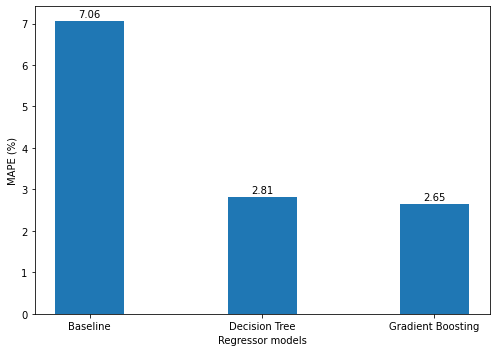

In [28]:
fig, ax = plt.subplots(figsize=(7, 5))

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
# ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

## Predict a sequence 

In [31]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['consumption'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['consumption'].shift(-output_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df

In [32]:
seq_df = window_input_output(26, 26, data)

In [26]:
seq_df

,co2,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25
1958-03-29,316.1,317.3,317.6,317.5,316.4,316.90,317.20,317.50,317.90,317.55,...,315.60,315.80,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.7
1958-04-05,317.3,317.6,317.5,316.4,316.9,317.20,317.50,317.90,317.55,317.20,...,315.80,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.7
1958-04-12,317.6,317.5,316.4,316.9,317.2,317.50,317.90,317.55,317.20,316.85,...,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.7
1958-04-19,317.5,316.4,316.9,317.2,317.5,317.90,317.55,317.20,316.85,316.50,...,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.70,317.1
1958-04-26,316.4,316.9,317.2,317.5,317.9,317.55,317.20,316.85,316.50,316.15,...,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.70,317.10,317.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-09,369.6,369.3,369.5,369.8,369.8,370.20,369.90,370.80,371.30,371.10,...,367.40,367.80,367.60,368.10,368.70,368.70,368.80,369.70,370.30,370.3
2000-12-16,369.3,369.5,369.8,369.8,370.2,369.90,370.80,371.30,371.10,371.70,...,367.80,367.60,368.10,368.70,368.70,368.80,369.70,370.30,370.30,370.8
2000-12-23,369.5,369.8,369.8,370.2,369.9,370.80,371.30,371.10,371.70,371.20,...,367.60,368.10,368.70,368.70,368.80,369.70,370.30,370.30,370.80,371.2
2000-12-30,369.8,369.8,370.2,369.9,370.8,371.30,371.10,371.70,371.20,372.20,...,368.10,368.70,368.70,368.80,369.70,370.30,370.30,370.80,371.20,371.3


In [35]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]

X_cols.insert(0, 'consumption')

y_cols = [col for col in seq_df.columns if col.startswith('y')]

In [36]:
X_train = seq_df[X_cols][:-2].values
y_train = seq_df[y_cols][:-2].values

X_test = seq_df[X_cols][-2:].values
y_test = seq_df[y_cols][-2:].values

### Apply a decision tree 

In [37]:
dt_seq = DecisionTreeRegressor(random_state=42)

dt_seq.fit(X_train, y_train)

dt_seq_preds = dt_seq.predict(X_test)

### Apply gradient boosting 

In [38]:
from sklearn.multioutput import RegressorChain

gbr_seq = GradientBoostingRegressor(random_state=42)

chained_gbr = RegressorChain(gbr_seq)

chained_gbr.fit(X_train, y_train)

gbr_seq_preds = chained_gbr.predict(X_test)

In [39]:
mape_dt_seq = mape(dt_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_dt_seq

0.0

In [40]:
mape_gbr_seq = mape(gbr_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_gbr_seq

5.19

In [41]:
mape_baseline = mape(X_test.reshape(1, -1), y_test.reshape(1, -1))
mape_baseline

8.25

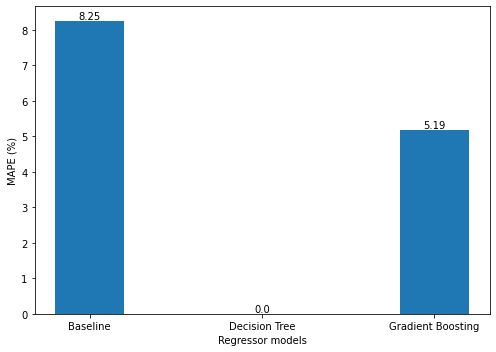

In [43]:
fig, ax = plt.subplots(figsize=(7, 5))

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [mape_baseline, mape_dt_seq, mape_gbr_seq]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
# ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()

In [44]:
len(dt_seq_preds[1])

26

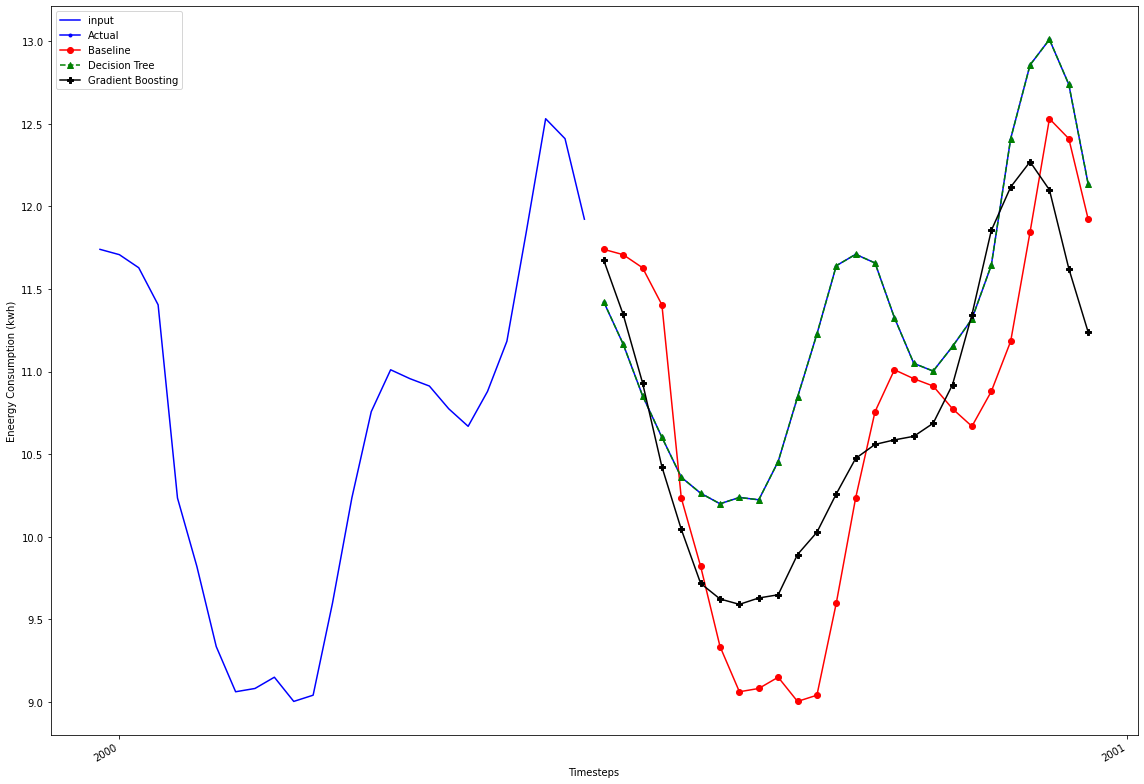

In [50]:
fig, ax = plt.subplots(figsize=(16, 11))

ax.plot(np.arange(0, 26, 1), X_test[1], 'b-', label='input')
ax.plot(np.arange(26, 52, 1), y_test[1], marker='.', color='blue', label='Actual')
ax.plot(np.arange(26, 52, 1), X_test[1], marker='o', color='red', label='Baseline')
ax.plot(np.arange(26, 52, 1), dt_seq_preds[1], marker='^', color='green', label='Decision Tree', linestyle='dashed')
ax.plot(np.arange(26, 52, 1), gbr_seq_preds[1], marker='P', color='black', label='Gradient Boosting')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Eneergy Consumption (kwh)')

plt.xticks(np.arange(1, 104, 52), np.arange(2000, 2002, 1))
plt.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()